# Recurrent Neural Network Classifier
Finds the tone of an article based on the article's headline, abstract and key words

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [19]:
# Load training data
train_df = pd.read_csv('../../data/cleaned_train.csv')
x_train = train_df['numerical_sequence'].apply(lambda x: [int(i) for i in x.split(',')])
y_train = np.array(train_df['BERT_sentiment_score'])

In [20]:
# Load test data
test_df = pd.read_csv('../../data/cleaned_test.csv')
x_test = np.array(test_df['numerical_sequence'].apply(lambda x: [int(i) for i in x.split(',')]))
y_test = np.array(test_df['BERT_sentiment_score'])

In [21]:
# Get the longest sequence
max_length = max([len(seq) for seq in x_test] + [len(seq) for seq in x_train])

# Pad sequences with zeros ro have the same length
x_train = pad_sequences(x_train, maxlen= max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen= max_length, padding='post', truncating='post')

In [22]:
# Training and validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [23]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               # Number of epochs to wait for improvement
                               patience=3,  
                               verbose=1, 
                               # Restore the weights of the best epoch
                               restore_best_weights=True)  

In [24]:
#Hyperparameters
num_classes = 3
# Get the maximum value across all elements in the combined array
x_combined = np.concatenate((x_train, x_test, x_val), axis=0)
vocab_size = np.max(x_combined) + 1

In [25]:
# Define the LSTM model architecture
model = Sequential()
# Input layer
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=x_train.shape[1]))
#Hidden layers
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Flatten())
# Output layer
model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 227, 32)           1222944   
                                                                 
 bidirectional_6 (Bidirectio  (None, 227, 100)         33200     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 227, 100)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 227, 100)         60400     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 227, 100)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 227, 100)        

In [26]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_val, y_val), 
         callbacks=[early_stopping])

Epoch 1/3
623/623 [==============================] - 282s 435ms/step - loss: 0.9568 - accuracy: 0.5361 - val_loss: 0.8575 - val_accuracy: 0.6157
Epoch 2/3
623/623 [==============================] - 248s 398ms/step - loss: 0.7067 - accuracy: 0.6769 - val_loss: 0.8409 - val_accuracy: 0.6462
Epoch 3/3
623/623 [==============================] - 253s 406ms/step - loss: 0.4432 - accuracy: 0.8176 - val_loss: 0.9201 - val_accuracy: 0.6494


In [27]:
# save the trained model
model.save('../../models/RNN_classification_model.h5')

In [28]:
model = load_model('../../models/RNN_classification_model.h5')

In [29]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(x_val, y_val)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

78/78 [==============================] - 14s 140ms/step - loss: 0.9201 - accuracy: 0.6494
Validation loss: 0.9201454520225525
Validation accuracy: 0.6494183540344238


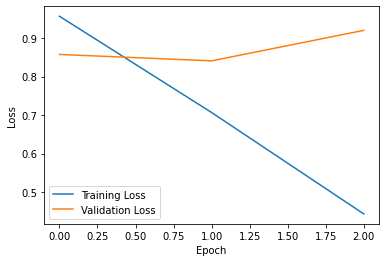

In [30]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()